##### Copyright 2024 Google LLC.

In [13]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bonus Day - So long and farewell!

Congrats on finishing the 5-day Generative AI Intensive course from Kaggle and Google!

This notebook is a "bonus episode" that highlights a few more things you can do with the Gemini API that weren't covered during the course. This material doesn't pair with the whitepapers or podcast, but covers some extra features that you might find useful when building Gemini API powered apps.

## Get set up

Install the SDK and other tools for this notebook, then import the package and set up a retry policy so you don't have to manually retry when you hit a quota limit.

In [14]:
%pip install -q google-generativeai pydub

Note: you may need to restart the kernel to use updated packages.


You do not have to restart the kernel.

In [15]:
import google.generativeai as genai
from google.api_core import retry

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)} 

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [16]:
import os
from dotenv import load_dotenv
   
   
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

In [17]:
#from kaggle_secrets import UserSecretsClient

#GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)

## Multi-modal prompting

As you may have noticed in AI Studio, the Gemini models support more than just text as input. You can provide pictures, videos, audio and more.


### Images

Start by downloading an image.

'wget' is not recognized as an internal or external command,
operable program or batch file.


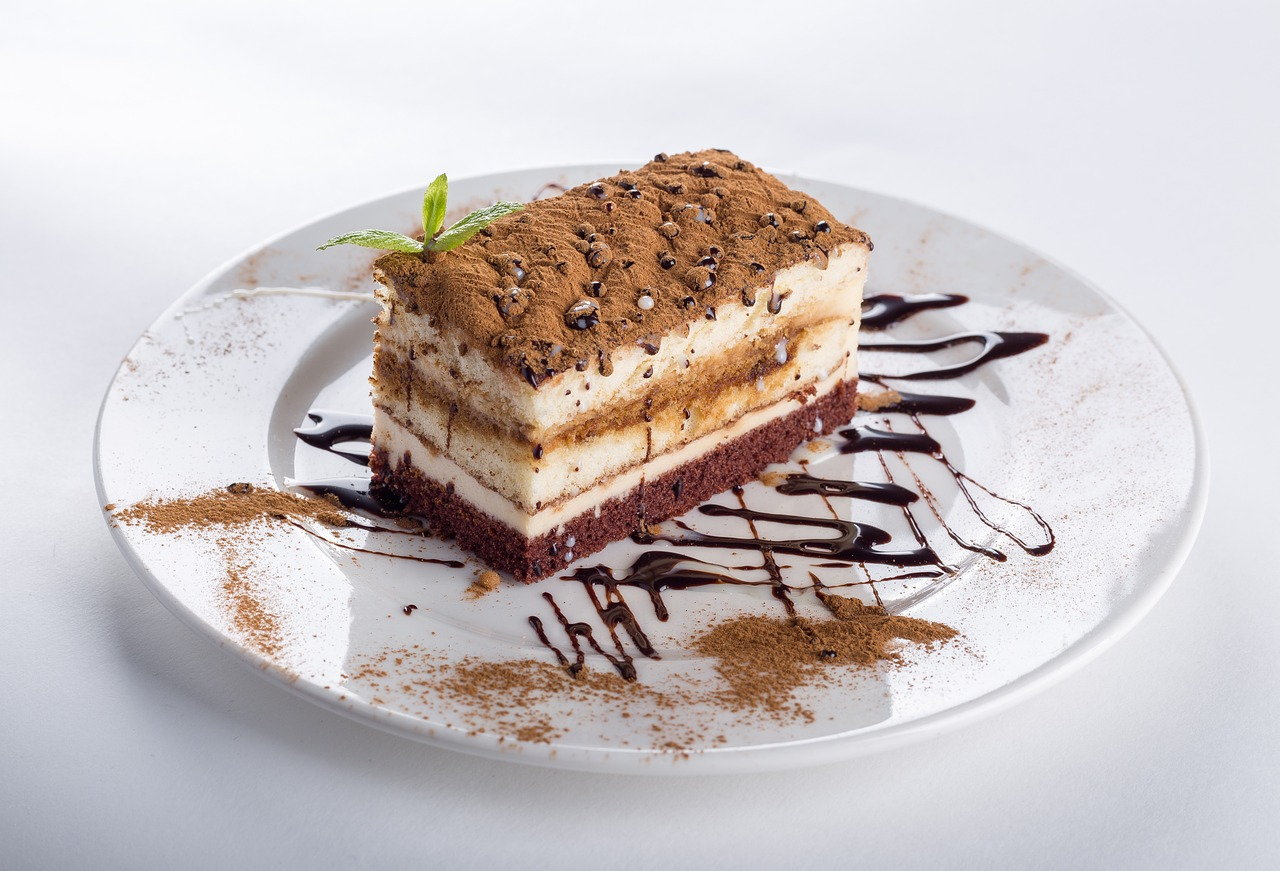

In [26]:
import PIL
from IPython.display import Image

!wget -nv https://storage.googleapis.com/generativeai-downloads/images/cake.jpg
Image('cake.jpg', width=500)

The Python SDK can take a list as the prompt input. This list represents a sequence of prompt parts, and while each part needs to be a single mode (such as text or image), you can combine them together to form a multi-modal prompt.

In [34]:
model = genai.GenerativeModel('gemini-1.5-flash-latest')

prompt = [
  "What is this? and how do you make it? and please explain in detail to me as if I am a twenty years old",
  PIL.Image.open("cake.jpg"),
]

response = model.generate_content(prompt, request_options=retry_policy)
print(response.text)

That's a slice of **tiramisu**.  It's an iconic Italian dessert known for its creamy, coffee-soaked layers and rich chocolate dusting. Think of it as a sophisticated, layered coffee cake.

Making tiramisu at home might seem intimidating, but it's actually quite manageable, especially if you break it down into steps. Here's how to make a classic version:

**Ingredients:**

* **For the Ladyfingers (Savoiardi):**  You can buy these pre-made at most grocery stores – baking them from scratch is a whole other project!
* **For the Coffee Mixture:**
    * Strong brewed coffee (espresso is ideal, but strong drip coffee works too), cooled.
    * Coffee liqueur (like Kahlúa) – optional but adds a nice kick.  If you omit this, add a teaspoon of vanilla extract for flavor.
    * A little bit of sugar, to taste (optional). Adjust this to your preference!
* **For the Mascarpone Cream:**
    * 8 ounces mascarpone cheese (this is a soft, creamy Italian cheese - crucial to the recipe)
    * 1 cup heavy 

This is a photo of two people, an adult and a child, flying a kite on a beach.  The adult appears to be a man and the child a boy.  They are both wearing red t-shirts with some sort of logo.  The background shows a pier and the ocean.

The photo looks good.  It's a well-composed shot, with good lighting and clear subject matter. The kite is colorful against the muted background.

It's impossible to definitively determine the ethnicity of the individuals in the photograph from the image alone.  The photo does not provide enough visual information to make a reliable assessment of race or origin.



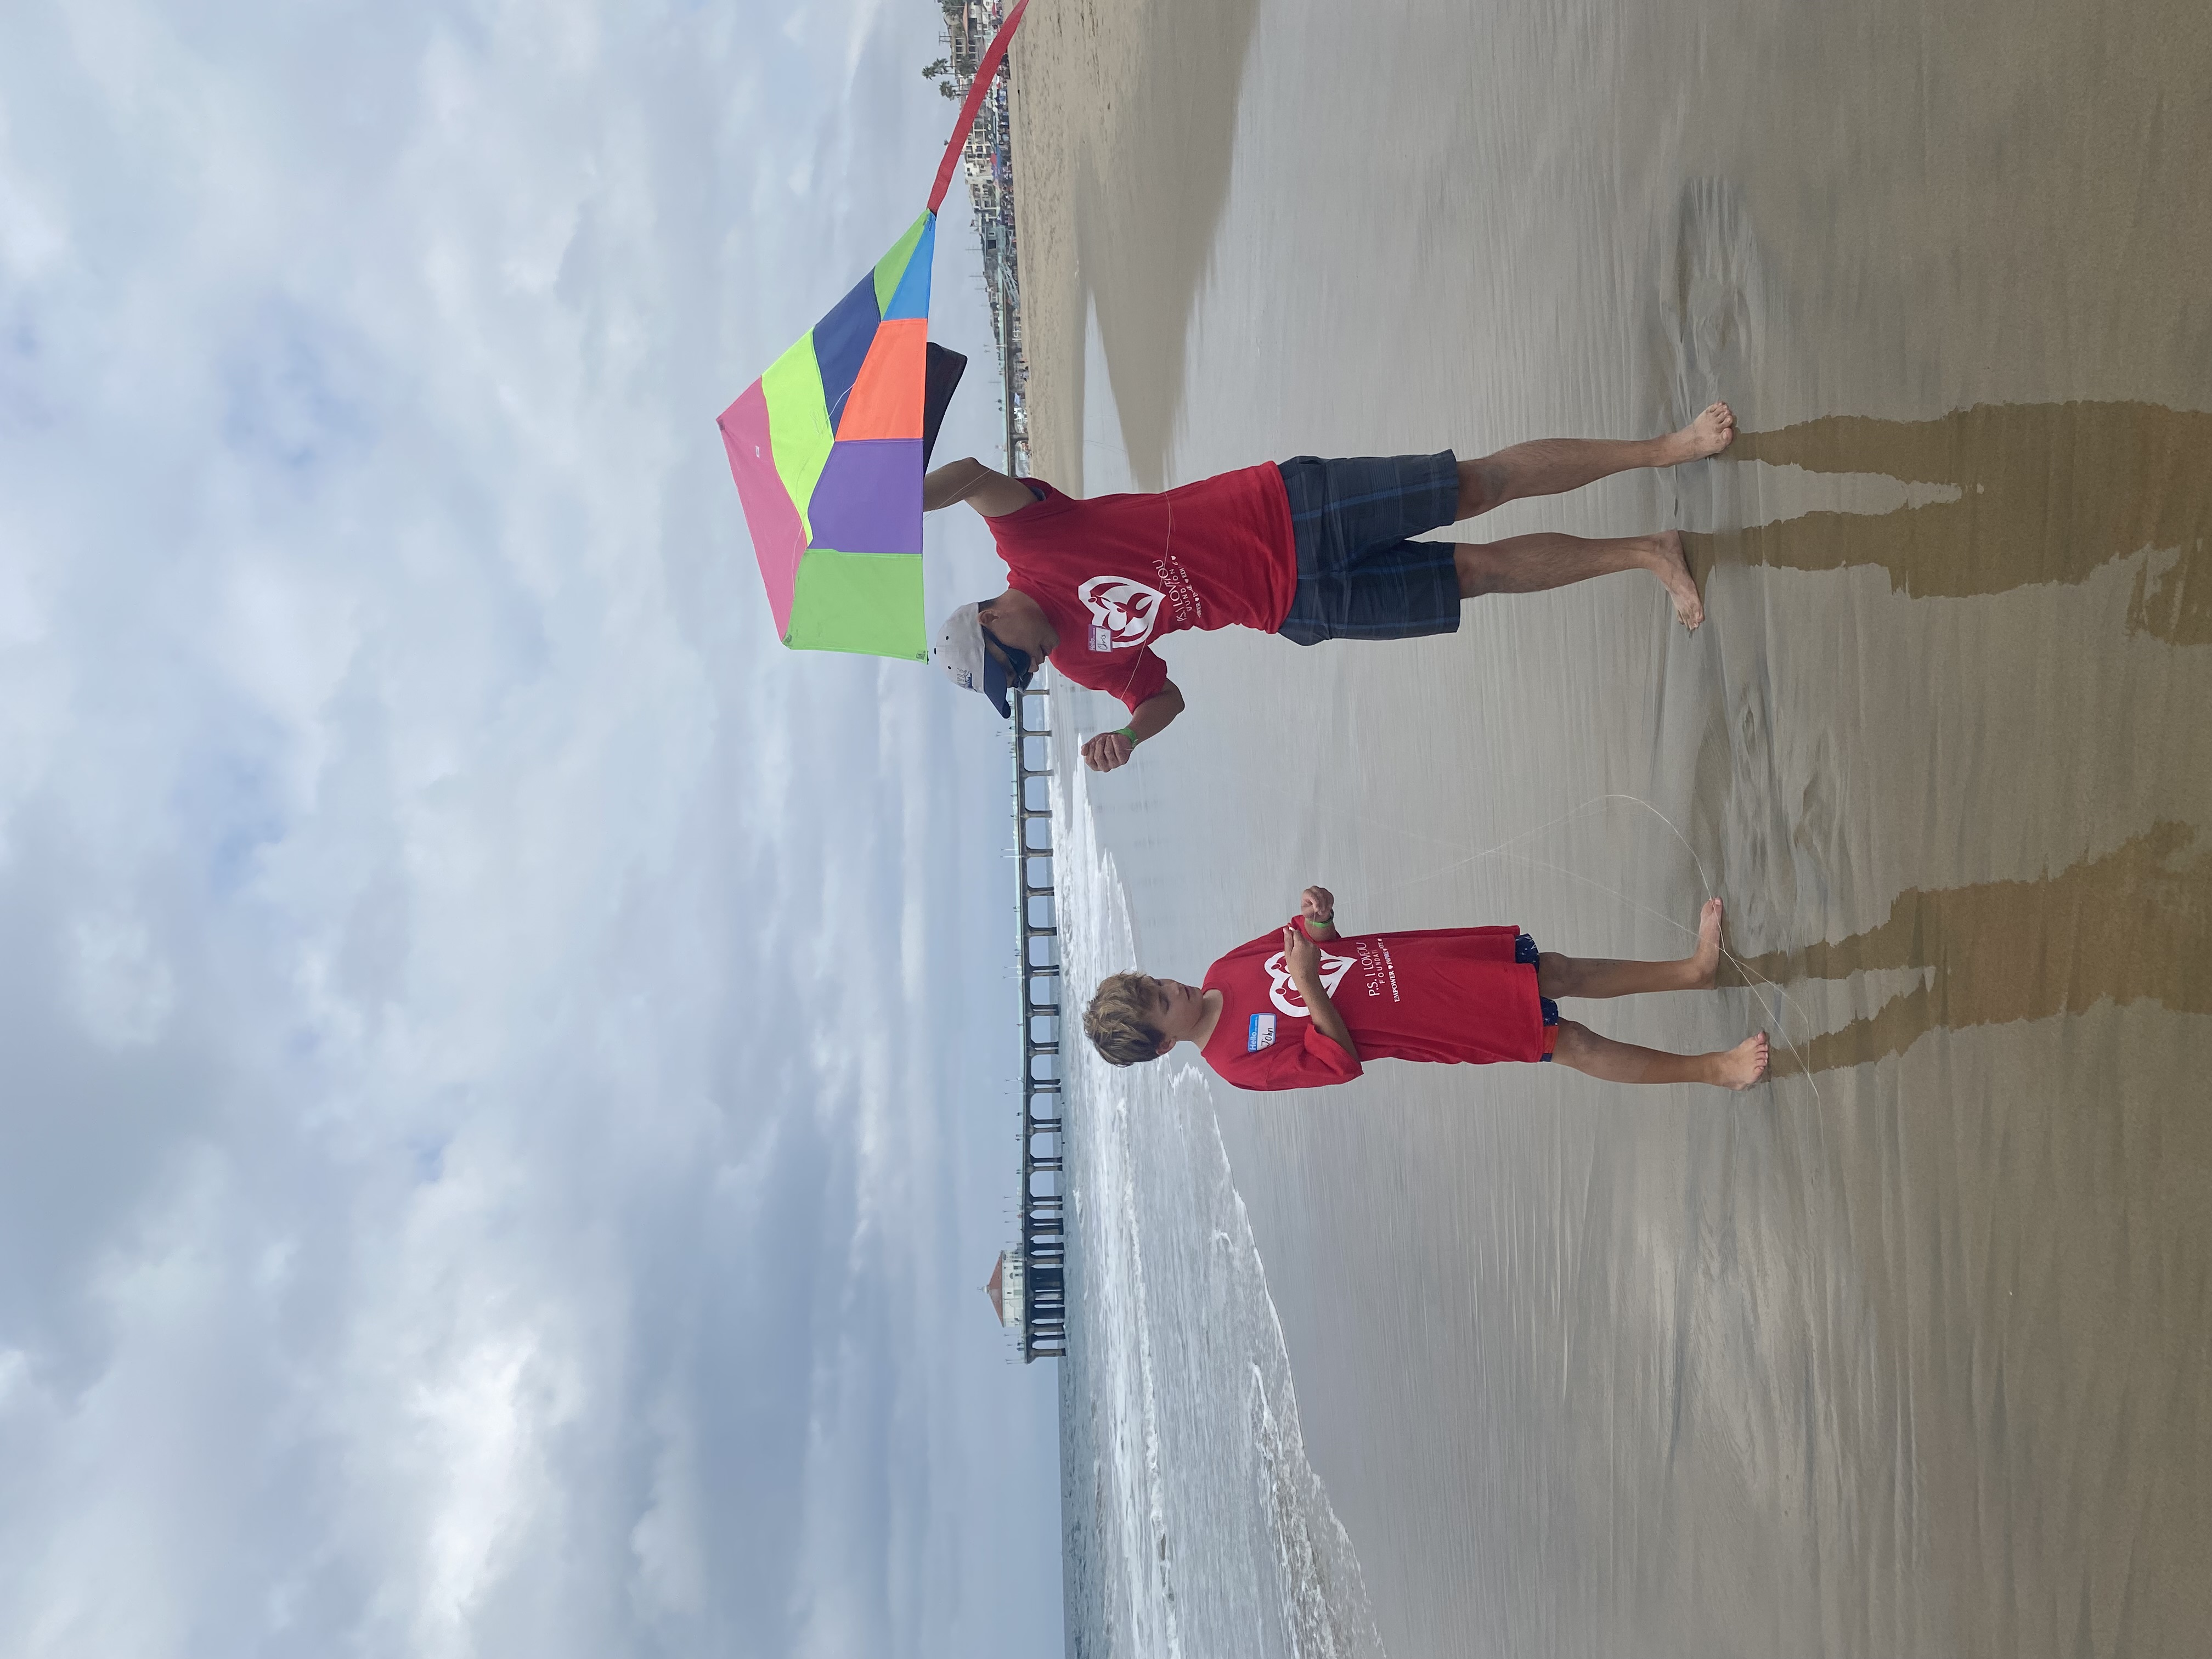

In [51]:
model = genai.GenerativeModel('gemini-1.5-flash-latest')

# Update the path to the image file
image_path = r"C:\Users\chris\Desktop\Photo3.jpg"  

prompt = [
  " what is this? does it look good? tell me the ethnicity of the people in the photo.",
  PIL.Image.open(image_path),
]

response = model.generate_content(prompt, request_options=retry_policy)
print(response.text)

Image(image_path, width=500)


Image understanding in the Gemini models can be quite powerful. Check out [this guide on object detection](https://github.com/google-gemini/cookbook/blob/main/examples/Object_detection.ipynb), where the Gemini API identifies and highlights objects in an image based on a prompt.

More input modes are supported, but first take a look at how to handle large files.

## Use and upload files

The Gemini models have very large context windows, up to 2 million input tokens are supported for the 1.5 Pro model. This translates to up to 2 hours of video or up to 19 hours of audio.

As files of this length are typically too large to send in HTTP requests, the Gemini API provides a File API to that you can use to send large files in requests. It also means you can reuse the same files across different requests without having to re-upload the same content each time, improving your request latency.

Note that some file limits exist, including how long they are kept. See [the note in the docs](https://ai.google.dev/gemini-api/docs/vision?hl=en&lang=python#upload-image) for more info.

### Audio

The Gemini API supports audio as an input medium. If you are the kind of person that takes audio notes with the Recorder or Voice Memo apps, this can be an efficient way to interact with your recordings ([check out this example](https://github.com/google-gemini/cookbook/blob/main/examples/Voice_memos.ipynb)), but you are not limited to personal notes.

This MP3 audio recording is a State of the Union addess from US president Kennedy. Running the following code should give you a playable audio controller so you can listen to it.

In [21]:
from pydub import AudioSegment
from IPython.display import Audio


!wget -nv https://storage.googleapis.com/generativeai-downloads/data/State_of_the_Union_Address_30_January_1961.mp3 -O speech.mp3

# This audio file is over 40mb, so trim the file before sending it to your browser.
full_speech = AudioSegment.from_mp3("speech.mp3")

# Preview the first 30 seconds.
first_30s_speech = full_speech[:30000]
first_30s_speech

# If you want to download and listen to the whole file, uncomment this.
# Audio("speech.mp3")

'wget' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [Errno 2] No such file or directory: 'speech.mp3'

Now upload the full file so it can be used in a prompt.

In [ ]:
uploaded_speech = genai.upload_file(path='speech.mp3')

In [ ]:
prompt = "Who made the following speech? What were they positive about?"

model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content([prompt, uploaded_speech], request_options=retry_policy)
print(response.text)

### Video



Now try out video understanding. In this example you will upload the ["Big Buck Bunny"](https://peach.blender.org/) short film and use the Gemini API to ask questions.

> "Big Buck Bunny" is (c) copyright 2008, Blender Foundation / www.bigbuckbunny.org and [licensed](https://peach.blender.org/about/) under the [Creative Commons Attribution 3.0](http://creativecommons.org/licenses/by/3.0/) License.

Start by downloading the video to this notebook and then uploading to the File API.

In [16]:
from pytubefix import YouTube
from pytubefix.cli import on_progress

# Function to download a YouTube video
def download_youtube_video(video_url, output_path='.', filename=None):
    try:
        # Create a YouTube object
        yt = YouTube(video_url)

        # Select the highest resolution stream available
        stream = yt.streams.get_highest_resolution()

        # If a filename is provided, use it; otherwise, use the default title
        if filename is None:
            filename = yt.title 

        # Download the video
        stream.download(output_path=output_path, filename=filename)
        print(f"Download complete: {filename}")

    except VideoUnavailable:
        print("The video is unavailable.")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
if __name__ == "__main__":
    video_url = "https://www.youtube.com/watch?v=UnLM3lYg4Qk"  # Replace with your video URL
    download_youtube_video(video_url, output_path='C:/Users/chris/Downloads')  # Specify your output path

Download complete: Oscar award winning short movie "Sorry"


In [11]:
#!wget https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4

#!wget https://drive.google.com/file/d/1Rr4F9yaOBZ5fiogKBHd9Mupuiswbzoui/view/SORRY_OSCAR.mp4

#print("Uploading to the File API...")

# Define the path to your local video file
video_path = r"C:\Users\chris\Downloads\Oscar_Father and Daughter.mp4"

# Check if the file exists
if os.path.exists(video_path):
    try:
        # Upload the file using the genai library
        print("Uploading to the File API...")
        video_file = genai.upload_file(path=video_path)
        print("Upload complete")
        
        # Use the uploaded file in a prompt
        prompt = "What characters are in this movie?"
        model = genai.GenerativeModel('gemini-1.5-flash-latest')
        response = model.generate_content([prompt, video_file], request_options={"timeout": 600})
        print(response.text)
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print("The file does not exist at the specified path.")
print("Upload complete")

Uploading to the File API...
Upload complete
An error occurred: 400 The File miy6qgdcdhnw is not in an ACTIVE state and usage is not allowed.
Upload complete


Larger files can take some time to process when they upload. Ensure that the file is ready to use.

In [12]:
import time

while video_file.state.name == "PROCESSING":
    print('Waiting for video to be processed.')
    time.sleep(10)
    video_file = genai.get_file(video_file.name)

if video_file.state.name == "FAILED":
  raise ValueError(video_file.state.name)

print(f'Video processing complete: ' + video_file.uri)

Waiting for video to be processed.
Video processing complete: https://generativelanguage.googleapis.com/v1beta/files/miy6qgdcdhnw


Now that it is ready, use it in a prompt. Note that using large files in requests typically takes more time than a small text request, so increase the timeout and be aware that you may have to wait for this response.

In [14]:
prompt = "give me a plot summary that has 1000 words about this movie"

model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content([prompt, video_file],
                                  request_options=retry_policy | {"timeout": 600})
print(response.text)

Certainly! Here is a plot summary of the short animated film *Father and Daughter* that is at least 1000 words in length.

The film opens with a sweeping shot of a bleak, snow-covered landscape under a pale sky.  A small child, a girl of perhaps five or six years of age, walks hand-in-hand with a tall man, presumably her father.  They are dwarfed by the immensity of the surroundings, the vast expanse of white punctuated only by the occasional dark silhouette of a tree.  The scene is set with a sense of quiet melancholy, the music hinting at a profound sadness beneath the surface.  The camera pulls back, revealing the title card: *Father and Daughter*, a film by Michael Dudok de Wit.

The narrative jumps forward in time, decades perhaps, to reveal the father and daughter again. They are now significantly older, the father noticeably aged, and the daughter a young woman. They are riding bicycles down a long, straight road, the same stark, minimalist style of animation conveying the passa

## Streaming

So far, you have been making transactional requests with the Gemini API - send the request, receive a full response. The API also supports response streaming.

Pass `stream=True` to `generate_content` to trigger streaming mode. Note that it may render quickly - uncomment the final `print` to see each streamed chunk on its own.

In [ ]:
prompt = """Write an essay defending why dogs are the best animals.
Treat the essay as serious and include proper essay structure."""

model = genai.GenerativeModel('gemini-1.5-flash-latest')

response = model.generate_content(prompt, stream=True, request_options=retry_policy)
for chunk in response:
    print(chunk.text, end='')
    # Uncomment this to see the individual tokens in separate sections.
    # print("\n----")

## Context caching

Context caching is a technique that allows you to cache part of a request, such that it does not need to be re-processed by the model each time you use it. This is useful, for example, for asking new questions of the same documents.

Note that context caching typically charges per million tokens per hour of caching. If you are using a paid API key, be sure to set your cache expiry or delete the cached tokens after use. See the [billing page](https://ai.google.dev/pricing) for more info. The Flash 1.5 model also supports caching on the free tier.

To ensure that the cache remains valid, caches are created by specifying versioned model names, so `gemini-1.5-flash-001`, where `-001` signifies the model version.

In [ ]:
from google.generativeai import caching

# Download the transcript
!wget -O apollo11.txt https://storage.googleapis.com/generativeai-downloads/data/a11.txt

# Upload to the File API
transcript_file = genai.upload_file('apollo11.txt')

# Create a cache
apollo_cache = caching.CachedContent.create(
    model='gemini-1.5-flash-001',
    system_instruction="You are a space history buff that enjoys discussing and explaining historical space events.",
    contents=[transcript_file],
)

apollo_cache

Now you can create a new model that uses this cache.

In [ ]:
from IPython.display import Markdown

apollo_model = genai.GenerativeModel.from_cached_content(cached_content=apollo_cache)

response = apollo_model.generate_content("Find a nice moment from this transcript")
Markdown(response.text)

The response object includes information about the number of tokens that were cached and otherwise used in the prompt.

In [ ]:
response.usage_metadata

And you can calculate how many non-cached tokens were used as input.

In [ ]:
response.usage_metadata.total_token_count - response.usage_metadata.cached_content_token_count

### Delete the cache

To ensure you are not charged for any cached tokens you are not using, delete the cache. If you are on the free tier, you won't be charged, but it's good practice to clean up when you're done.

In [ ]:
print(apollo_cache.name)
apollo_cache.delete()

## Further reading

Take a look through the [Gemini API cookbook](https://github.com/google-gemini/cookbook) for more feature-based quickstarts and complex examples.

If you enabled billing on your API key and are finished with the key, you can [turn it off](https://ai.google.dev/gemini-api/docs/billing) unless you plan on using it again.

And thank you for coming with us on this 5-day learning journey!

\- [Mark McD](https://twitter.com/m4rkmc)